In [1]:
import tensorflow as tf
tf.enable_eager_execution()

C:\Users\Chanchala\Miniconda3\envs\tensorflow-quant\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chanchala\Miniconda3\envs\tensorflow-quant\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chanchala\Miniconda3\envs\tensorflow-quant\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\U

In [2]:
import numpy as np

import sys
import os

if sys.version_info.major >= 3:
    import pathlib
else:
    import pathlib2 as pathlib

In [3]:
archive_path = tf.keras.utils.get_file("resnet_v2_101.tgz", "https://storage.googleapis.com/download.tensorflow.org/models/tflite_11_05_08/resnet_v2_101.tgz", extract=True)
archive_path = pathlib.Path(archive_path)
archive_dir = str(archive_path.parent)

In [4]:
!type {archive_dir}\resnet_v2_101_299_info.txt

Model: resnet_v2_101
Input: input
Output: output


Quantizing weights
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision.
At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation. Hybrid ops are available for the most compute-intensive operators in a network:

tf.contrib.layers.fully_connected
tf.nn.conv2d
tf.nn.embedding_lookup
BasicRNN
tf.nn.bidirectional_dynamic_rnn for BasicRNNCell type
tf.nn.dynamic_rnn for LSTM and BasicRNN Cell types

https://www.tensorflow.org/lite/performance/post_training_quantization#quantizing_weights

In [5]:
graph_def_file = pathlib.Path(archive_path).parent/"resnet_v2_101_299_frozen.pb"
input_arrays = ["input"] 
output_arrays = ["output"]
converter = tf.lite.TFLiteConverter.from_frozen_graph(
  str(graph_def_file), input_arrays, output_arrays, input_shapes={"input":[1,299,299,3]})
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
resnet_tflite_file = graph_def_file.parent/"resnet_v2_101_quantized.tflite"
resnet_tflite_file.write_bytes(converter.convert())

44997256

In [ ]:
!dir /s {archive_dir}\*.tflite

In [ ]:
tf.logging.set_verbosity(tf.logging.DEBUG)

In [ ]:
#Quantizing using a saved_model
converter = tf.lite.TFLiteConverter.from_saved_model("C:\\Users\\Chanchala\\resnet50_v2\\NHWC")  
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
resnet_tflite_path = pathlib.Path("C:\\Users\\Chanchala\\resnet50_v2\\NHWC")
resnet_tflite_file = resnet_tflite_path/"resnet_v2_101_quantized_from_saved_model.tflite"
resnet_tflite_file.write_bytes(converter.convert())

In [11]:
from os import listdir
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

input_dir = "D:\\Imagenet\\test_5"
inputfiles = [f for f in listdir(input_dir)]

input_gen_list = []
for a in inputfiles:
    im = cv2.imread(f'{input_dir}\\{a}')
    im2 = cv2.resize(im, (299,299))
    #print(im2.shape)
    #plt.imshow(im2)
    im3 = im2.astype(dtype=np.float32)/255
    data_last = np.stack([im3]*1)
    input_gen_list.append(data_last)

Full integer quantization of weights and activations

We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.
https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization_of_weights_and_activations

In [12]:
def representative_data_gen():
  for input_value in input_gen_list:
    yield [input_value]

graph_def_file = pathlib.Path(archive_path).parent/"resnet_v2_101_299_frozen.pb"
input_arrays = ["input"] 
output_arrays = ["output"]
converter = tf.lite.TFLiteConverter.from_frozen_graph(
  str(graph_def_file), input_arrays, output_arrays, input_shapes={"input":[1,299,299,3]})
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen

resnet_tflite_file = graph_def_file.parent/"resnet_v2_101_quantizedfully.tflite"
resnet_tflite_file.write_bytes(converter.convert())

46105840

In [13]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="C:\\Users\\Chanchala\\.keras\\datasets\\resnet_v2_101_quantizedfully.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

In [14]:
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'input', 'index': 501, 'shape': array([  1, 299, 299,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'output', 'index': 502, 'shape': array([   1, 1001]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [8]:
# Test model on random input data.
input_shape = input_details[0]['shape']
print (input_shape)
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print (input_data.shape)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[  1 299 299   3]
(1, 299, 299, 3)
[[-0.9783716  -1.4374633   0.5316028  ... -0.50486034 -1.1207626
   1.5864655 ]]


In [15]:
%matplotlib inline

(299, 299, 3)
(1, 299, 299, 3)
[[ 0.18472224 -0.8312501  -1.2930558  ... -1.0159724  -0.09236112
   0.        ]]
59


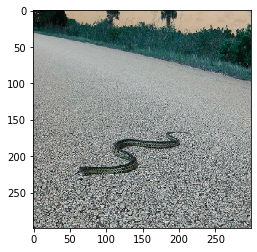

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
im = cv2.imread("D:\\Imagenet\\test_5\\ILSVRC2012_val_00000006.JPEG")
im2 = cv2.resize(im, (299,299))
print(im2.shape)
plt.imshow(im2)
im3 = im2.astype(dtype=np.float32)/255

data_last = np.stack([im3]*1)
print (data_last.shape)
interpreter.set_tensor(input_details[0]['index'], data_last)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print (np.argmax(output_data))

(368, 500, 3)
(1, 299, 299, 3)
<class 'numpy.ndarray'>
(1, 299, 299, 3)
[[ 0.         -1.0159724   0.8312501  ... -1.8472224   0.9236112
  -0.09236112]]
950


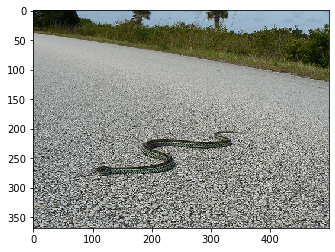

In [17]:

from PIL import Image 
import matplotlib.pyplot as plt
img = plt.imread("D:\\Imagenet\\test_5\\ILSVRC2012_val_00000006.JPEG")
plt.imshow(img)
print(img.shape)

img2 = Image.open("D:\\Imagenet\\test_5\\ILSVRC2012_val_00000099.JPEG")
img3 = img2.resize((299,299))
data_last = np.expand_dims(img3, axis=0)
print(data_last.shape)
print (type(data_last))

data = data_last.astype(dtype=np.float32)/255
print (data.shape)
#data_2 = data[0,:,:,0]
#print(data_2.shape)
#plt.imshow(data_2)
interpreter.set_tensor(input_details[0]['index'], data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print (np.argmax(output_data))


In [18]:
tf.nn.top_k(output_data, k=5, sorted=True, name=None)

TopKV2(values=<tf.Tensor: id=3776, shape=(1, 5), dtype=float32, numpy=
array([[16.994446 ,  7.2041674,  6.742362 ,  6.0958343,  5.6340284]],
      dtype=float32)>, indices=<tf.Tensor: id=3777, shape=(1, 5), dtype=int32, numpy=array([[950, 929, 928, 961, 869]])>)